In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.linalg import eigvalsh, eigh
from scipy.linalg import kron
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import transition
import spin
import angle
import hamiltonian

# The Hamiltonian



The Hamiltonian for VOporphirin is :

$$ H_S = \vec S \, \hat A \, \vec I + \mu_B \vec H \hat g \vec S $$


where both $\hat A$ and $\hat g$ are diagonal:

$$\hat A = {\rm diag}(A_x, A_y, A_z)$$
and
$$ \hat g = {\rm diag} (g_x, g_y, g_z)$$

Here
$$I=7/2$$
and 
$$S=1/2$$

We will use the angular momentum operator ladder operators $(S, I)$:
$$ S_+ |S, m \rangle = \hbar \sqrt{S(S+1) - m (m+1)} \; | S m+1 \rangle $$
and
$$ S_- |S, m+1 \rangle = \hbar \sqrt{S(S+1) - m (m+1)} \;  | S m \rangle $$

Then,
$$ S_x= \frac{1}{2} ( S_+ + S_-) $$
and
$$ S_y= \frac{-i}{2} ( S_+ - S_-) $$

Finally,

$$ S_z |S, m \rangle = \hbar m  \; | S m \rangle $$

According to measurement, the molecule $z$ axis can be written in spherical coordinates of the lab axes ($XYZ$) as $z = (\sin \theta \cos \phi, \sin \theta \sin \phi, \cos \theta)$. Owing to the symmetry of the molecule, the $x$ and $y$ axes can be chosen freely from the set of orthonormal pairs contained in the plane orthogonal to $z$. For simplicity, the $x$ axis is chosen to belong to the $XZ$ plane, with coordinates $x = (\sin \alpha, 0 , \cos \alpha)$. The angle $\alpha$ that the $x$ axis forms with the $Z$ axis is to be determined from the condition of orthogornality with the $z$ axis, yielding

$$ \tan \alpha = \frac{- \cot \theta }{\cos \phi} \,.$$ 

Finally, once $z$ and $x$ are set, the $y$ axis is defined by the right hand rule as $y = z \times x$. 

The Hamiltonian is written in terms of the molecule axes, whereas the DC and microwave fields will be given in terms of the lab axes, hence it is convenient express the lab axes in coordinates of the molecule axes, constructing and inverting the change of basis matrix.

In [2]:
# Define the lab axes
θ = angle.to_rad(64.82)
ϕ = angle.to_rad(72.39)
α = np.arctan(-np.cos(θ) / (np.sin(θ) * np.cos(ϕ))) + np.pi # the argument of the cot is negative so we add π

x = np.array([np.sin(α), 0, np.cos(α)])
z = np.array([np.sin(θ) * np.cos(ϕ), np.sin(θ) * np.sin(ϕ), np.cos(θ)])
y = np.cross(z, x)

M = np.array([x, y, z])

print(np.linalg.det(M)) #check unitarity

invM = np.linalg.inv(M)

X = M[0, :] # lab X axis in coordinates of the molecule axes
Y = M[1, :]
Z = M[2, :]

1.0


In [3]:
# parameters
A = np.array([0.172, 0.172, 0.475]) # units of GHz
g = 13.99 * np.array([1.99, 1.99, 1.963]) # units of GHz / T 
h_ext = 0.001 # 1 mT
th = 0.0002 # 0.2 MHz (corresponding to 5 μs)

## Plot of the raw transition matrix 

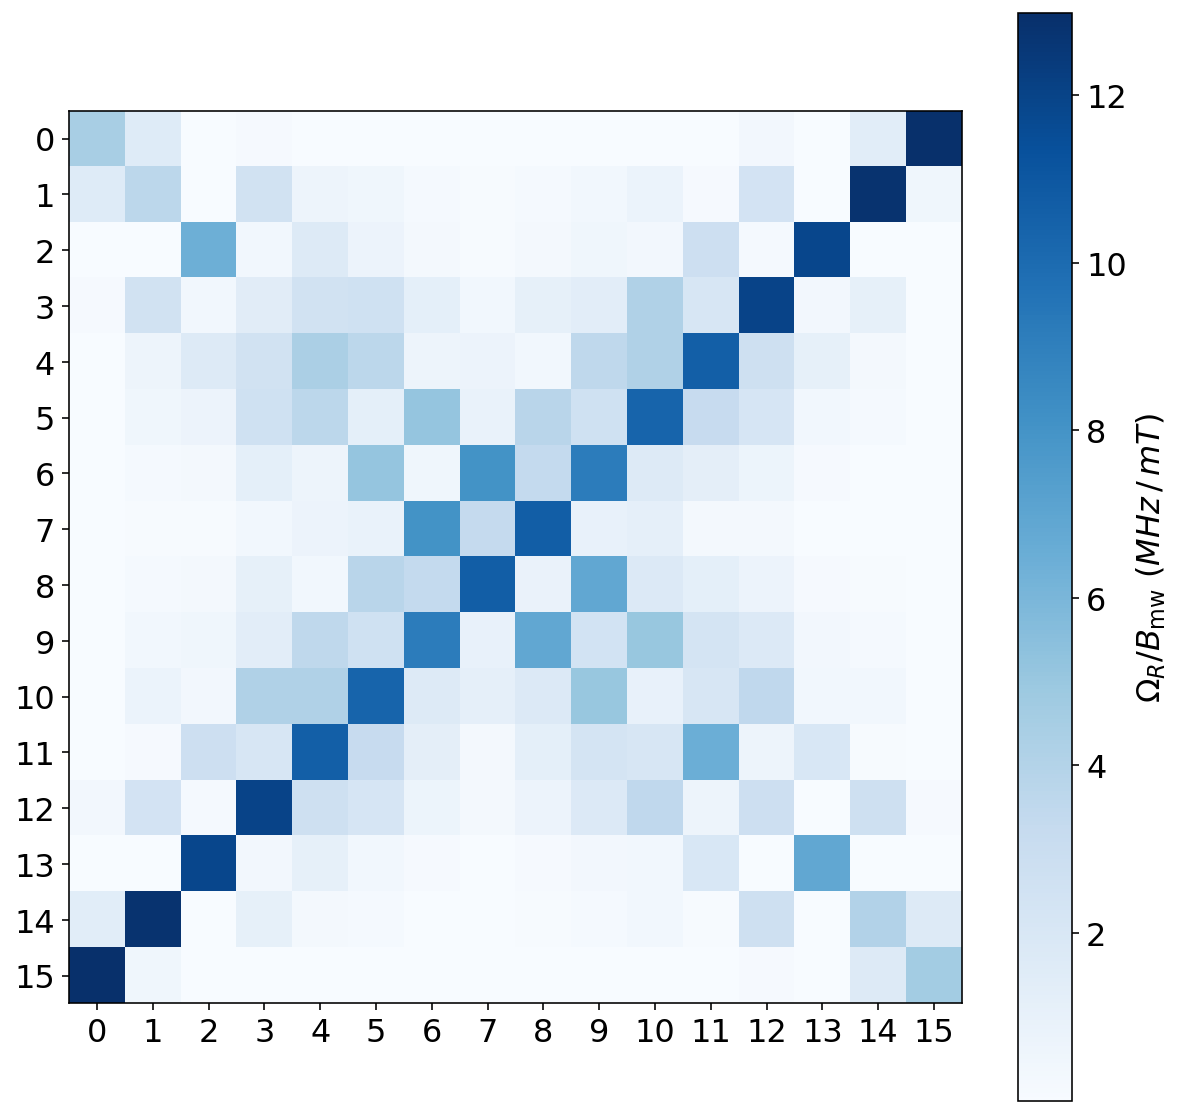

In [4]:
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 16

h = 0.02

H = hamiltonian.VOporphirin(A, g, h * X)
Hext = hamiltonian.external_field(h_ext * Z, g)

m = transition.transition_matrix(H, Hext)

plt.imshow(m / h_ext, cmap='Blues', interpolation='none')
plt.xticks(np.arange(0, m.shape[0], 1))
plt.yticks(np.arange(0, m.shape[0], 1))
plt.colorbar(label = r'$\Omega_R / B_{\rm mw} \ (MHz \, / \, mT)$')
plt.show()

## Identify addressable transtions

Of the raw transitions generated by the external field, eliminate those corresponding to degenerate transitions, i.e. keep only independently addressable transitions.

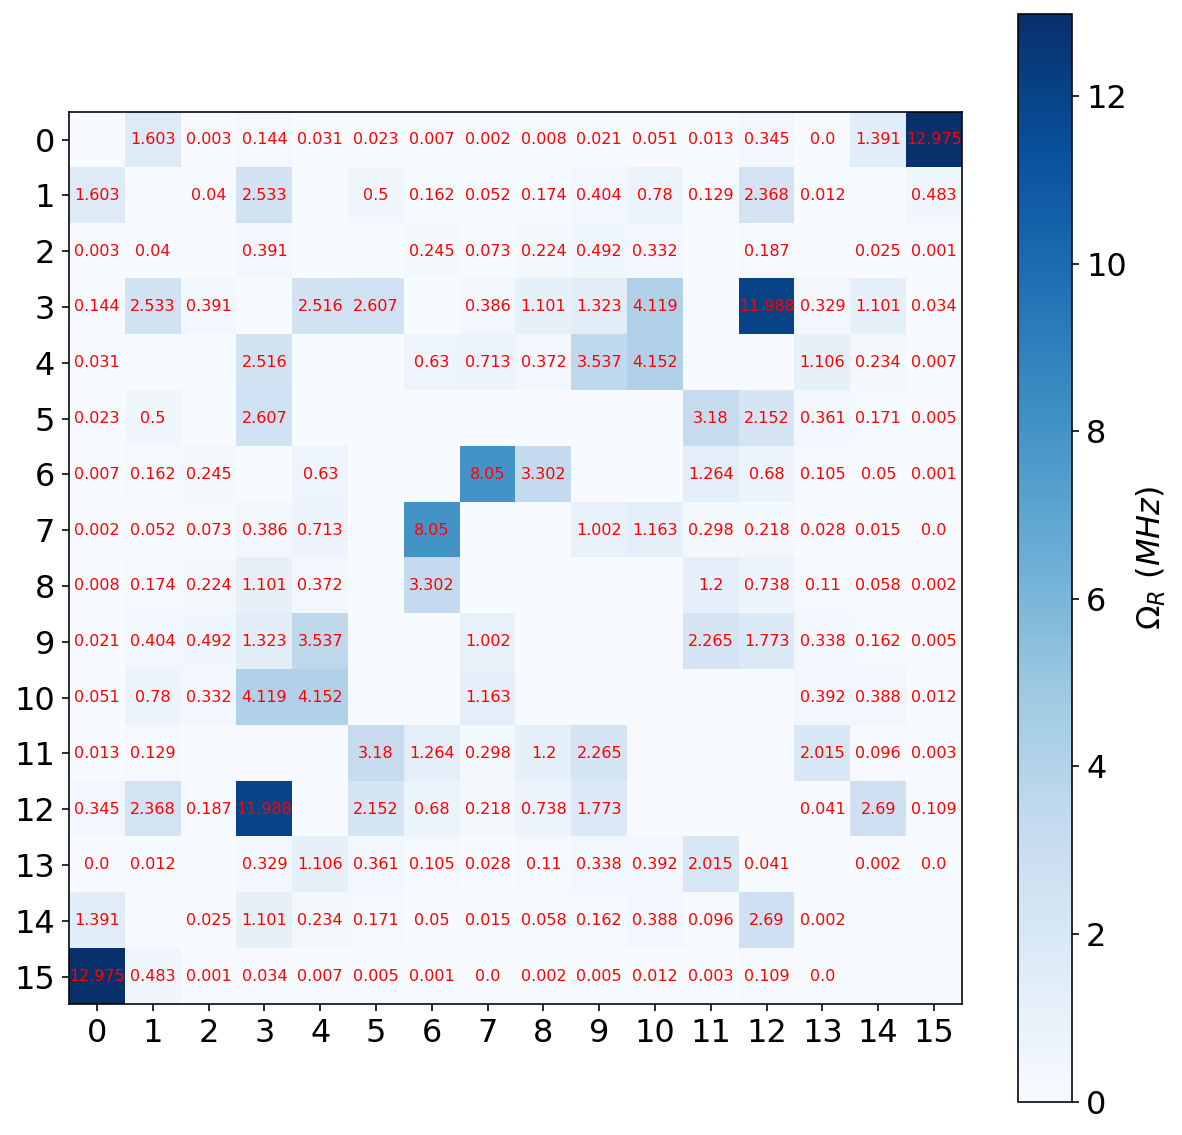

In [11]:
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 16

m_trans, degenerates = transition.select_transitions(m, vals)

plt.imshow(m_trans * 1000, cmap='Blues')
plt.clim(0, (np.amax(m_trans * 1000) > 0) * np.amax(m_trans * 1000) + (np.amax(m_trans * 1000) == 0) * 1)

for idx, val in np.ndenumerate(m_trans):
    if val:
        plt.text(idx[0], idx[1], round(val * 1000, 3), ha="center", va="center", color="r", size = 8)
        
plt.xticks(np.arange(0, vects.shape[1], 1))
plt.yticks(np.arange(0, vects.shape[1], 1))
plt.colorbar(label = r'$\Omega_R \ (MHz)$')

"""for idx in degenerates:
    plt.plot(idx[0], idx[1], marker = 'o', lw = 0, color="orange", ms = 7.5)
"""
plt.show()

## Optimize the transitions

Of the raw addressable transitions, some are very slow, so slow that they are effectively useless if one takes into account the decoherence time. Thus, we discard the slow raw transitions and replace them by compound transtitions that are faster. A fast transition, even if is the composition of several raw transitions, is better that a slow raw transition.

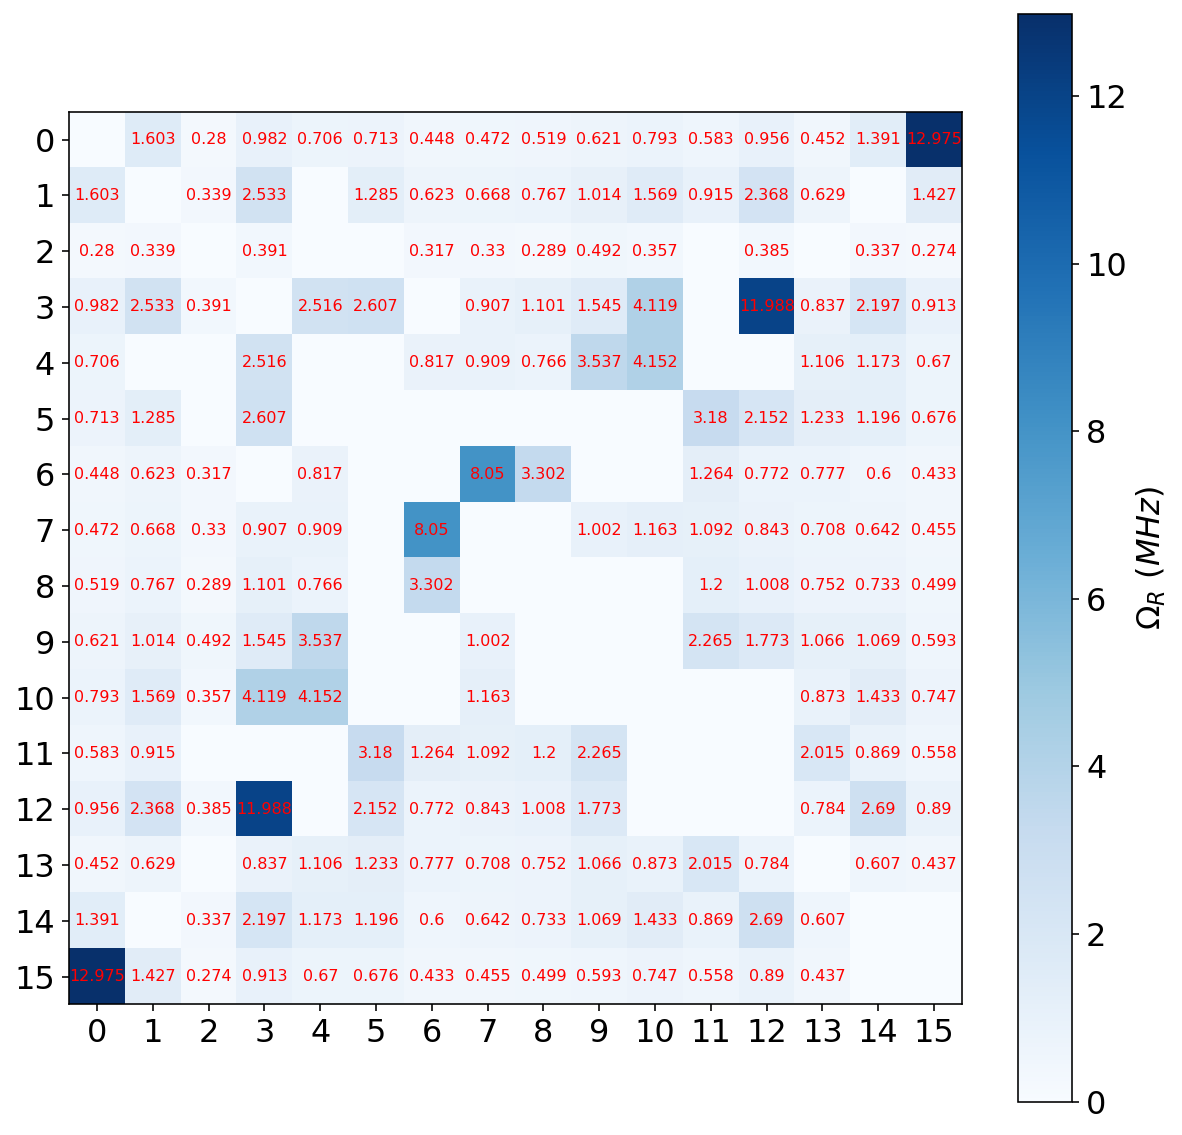

In [13]:
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 16

m_trans_opt = transition.optimize_transitions(m_trans, order = 5)

plt.imshow(m_trans_opt * 1000, cmap='Blues')
plt.clim(0, (np.amax(m_trans_opt * 1000) > 0) * np.amax(m_trans_opt * 1000) + (np.amax(m_trans_opt * 1000) == 0) * 1)

for idx, val in np.ndenumerate(m_trans_opt):
    if val:
        plt.text(idx[0], idx[1], round(val * 1000, 3), ha="center", va="center", color="r", size = 8)
        
plt.xticks(np.arange(0, vects.shape[1], 1))
plt.yticks(np.arange(0, vects.shape[1], 1))
plt.colorbar(label = r'$\Omega_R \ (MHz)$')
plt.show()

## Attempt to fill the remaining matrix elements

Now that we have optimized the raw transitions, we check if these can be compounded to generate the remaining transitions. 

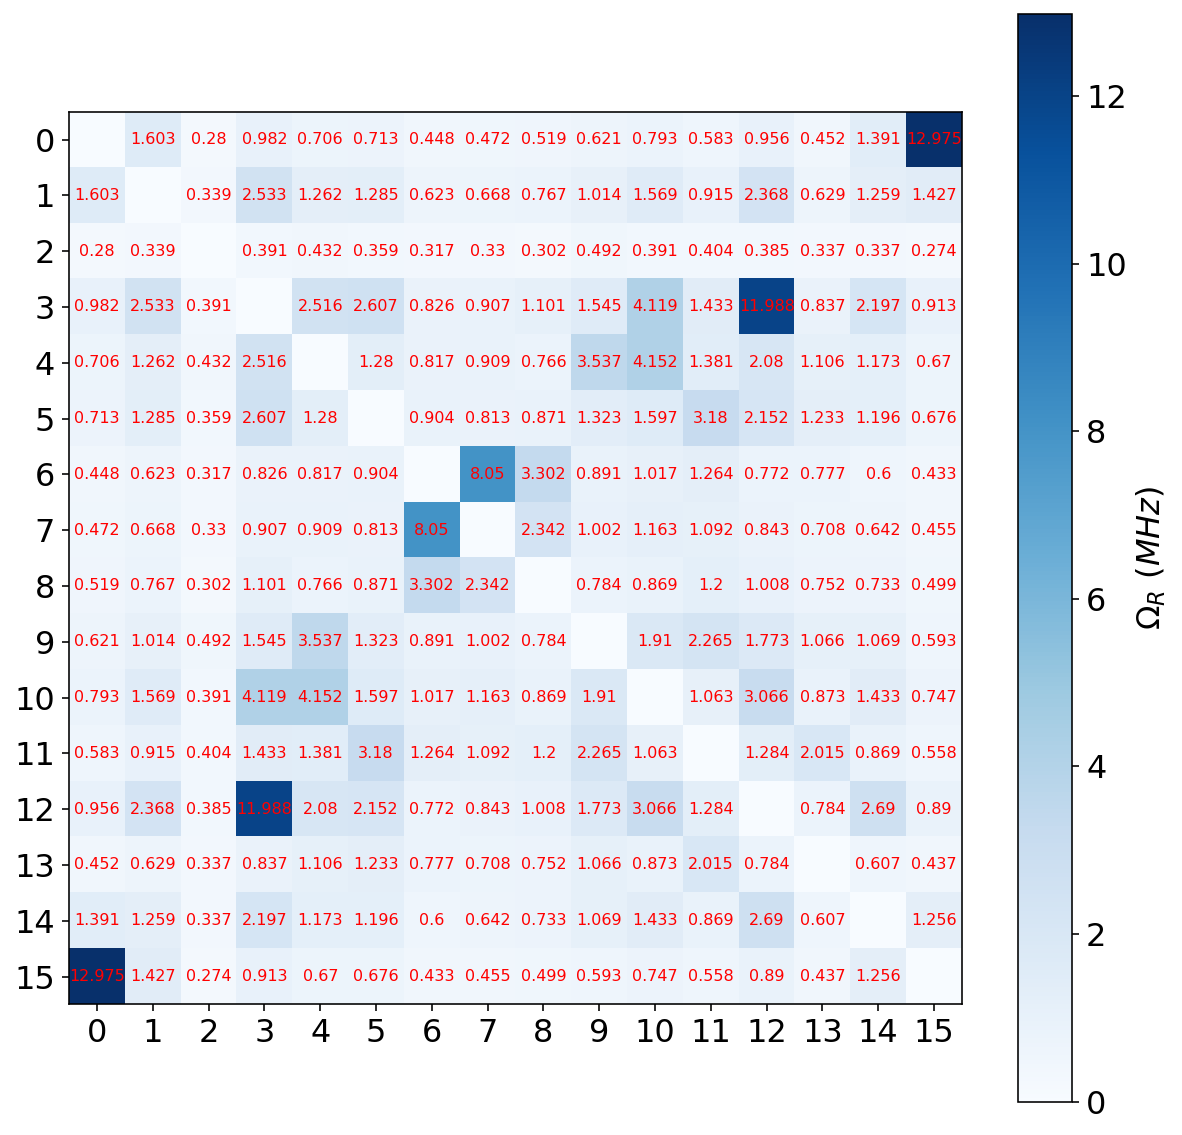

In [15]:
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 16

m_trans_ext = transition.fill_connections(m_trans_opt, order = 5)

plt.imshow(m_trans_ext * 1000, cmap='Blues')
plt.clim(0, (np.amax(m_trans_ext * 1000) > 0) * np.amax(m_trans_ext * 1000) + (np.amax(m_trans_ext * 1000) == 0) * 1)

for idx, val in np.ndenumerate(m_trans_ext):
    if val:
        plt.text(idx[0], idx[1], round(val * 1000, 3), ha="center", va="center", color="r", size = 8)
        
plt.xticks(np.arange(0, vects.shape[1], 1))
plt.yticks(np.arange(0, vects.shape[1], 1))
plt.colorbar(label = r'$\Omega_R \ (MHz)$')
plt.show()

## Measuring universality

At this point, we have a matrix containing the speed (energy) of all transitions (non addressable transitions will appear as zero), it is time to check if the slowest transitions are fast enough for the decoherence time of our system. We define as a measure of universality the ratio between the slowest transition and the threshold speed (energy).

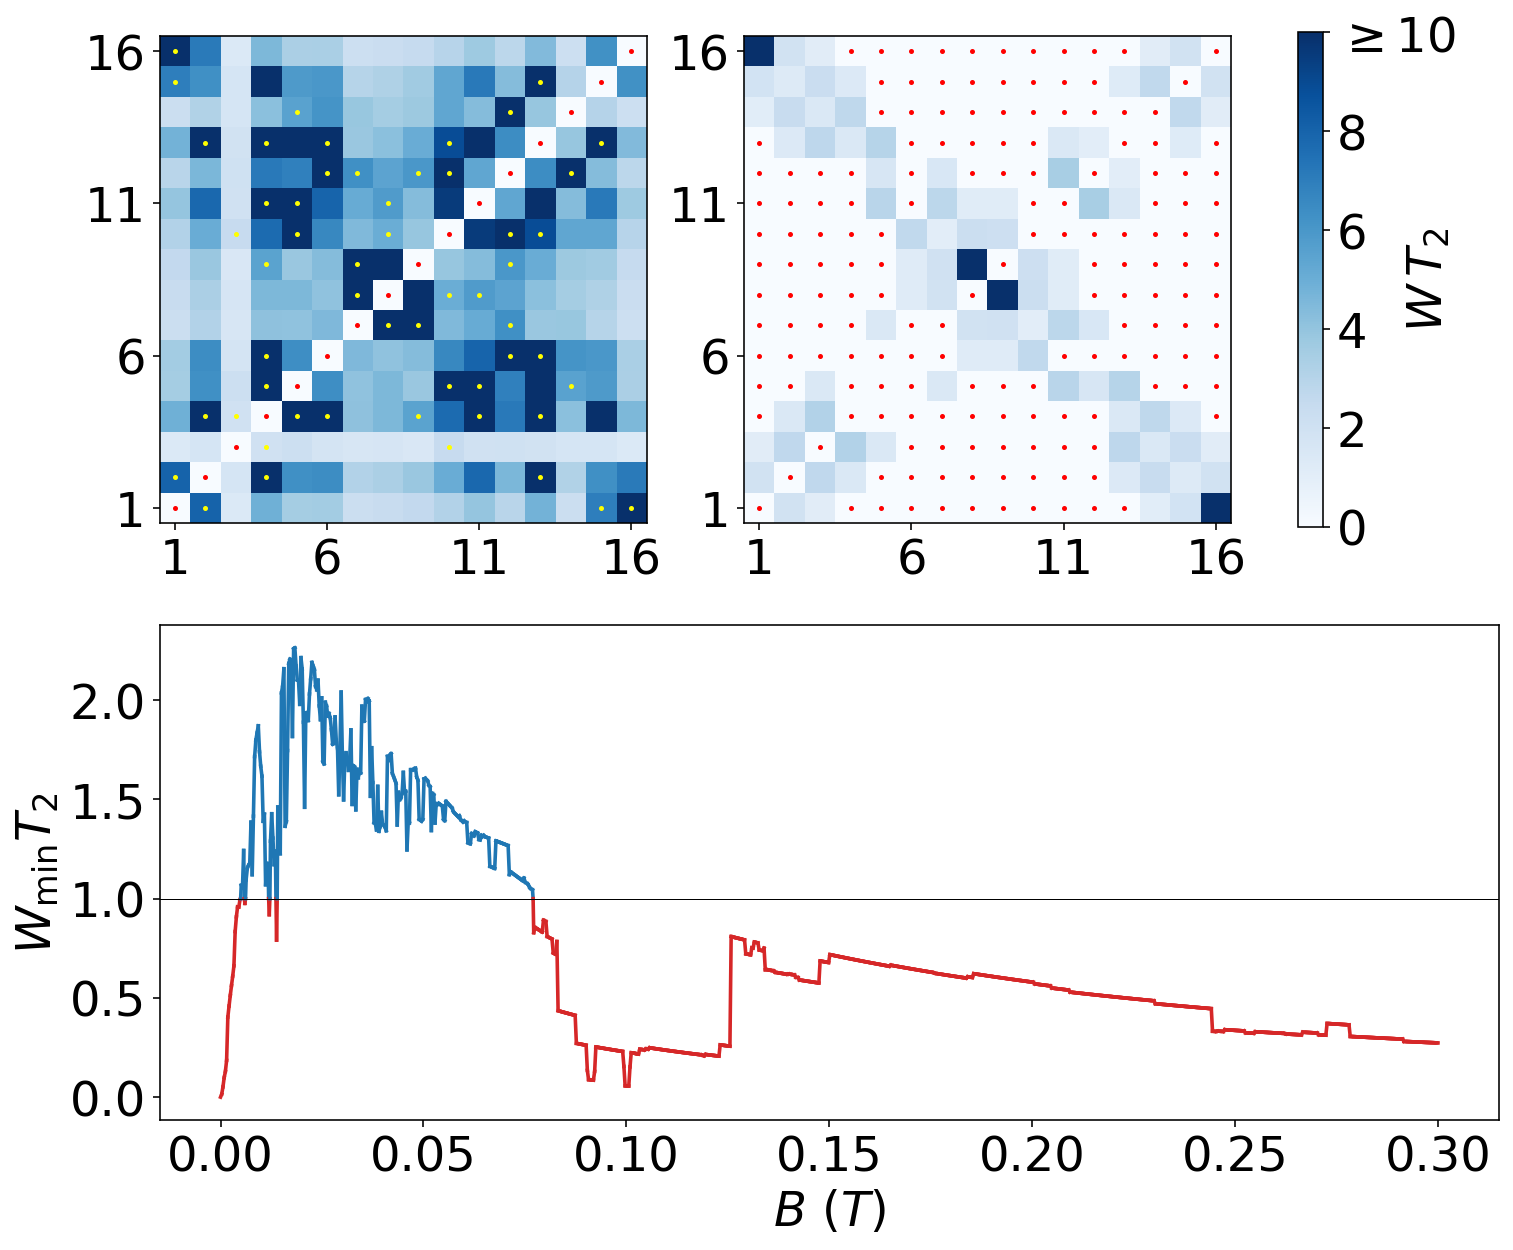

In [20]:
plt.rcParams['figure.figsize'] = 12, 10
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 24

fig = plt.figure()

ax1 = fig.add_subplot(221)

# left  upper plot

h = 0.02 

H = hamiltonian.VOporphirin(A, g, h * X)
Hext = hamiltonian.external_field(h_ext * Z, g)
vals, vects = eigh(H)

m = np.abs(np.conj(np.transpose(vects)) @ Hext @ vects)
m_trans, degenerates = transition.select_transitions(m, vals)
m_trans_ext = transition.fill_connections(m_trans, order = 5)
m_trans_purged = transition.apply_cutoff(m_trans_ext, th)

im = ax1.imshow(m_trans_purged / th, cmap='Blues', origin = 'lower')
im.set_clim(0, 10)

for idx, val in np.ndenumerate(m_trans_purged):
    if val == 0.0:
        ax1.plot(idx[0], idx[1], marker = 'o', lw = 0, color="r", ms = 1.5)
        
for idx, val in np.ndenumerate(m_trans_ext - m_trans):
    if val == 0.0 and idx[0] != idx[1]: # if the value has not changed it means that the original transition is the best option
        ax1.plot(idx[0], idx[1], marker = 'o', lw = 0, color="yellow", ms = 1.5)
        
"""for idx in degenerates:
    axes[0].plot(idx[0], idx[1], marker = 'o', lw = 0, color="orange", ms = 7.5)"""
        
ax1.set_xticks(np.arange(0, vects.shape[1], 5))
ax1.set_xticklabels(np.arange(1, vects.shape[1] + 1, 5))
ax1.set_yticks(np.arange(0, vects.shape[1], 5))
ax1.set_yticklabels(np.arange(1, vects.shape[1] + 1, 5))

# left lower plot

ax2 = fig.add_subplot(222)

h = 0.3 

H = hamiltonian.VOporphirin(A, g, h * X)
Hext = hamiltonian.external_field(h_ext * Z, g)
vals, vects = eigh(H)

m = np.abs(np.conj(np.transpose(vects)) @ Hext @ vects)
m_trans, degenerates = transition.select_transitions(m, vals)
m_trans_ext = transition.fill_connections(m_trans, order = 5)
m_trans_purged = transition.apply_cutoff(m_trans_ext, th)

im = ax2.imshow(m_trans_purged / th, cmap='Blues', origin='lower')
im.set_clim(0, 10)

for idx, val in np.ndenumerate(m_trans_purged):
    if val == 0.0:
        ax2.plot(idx[0], idx[1], marker = 'o', lw = 0, color="r", ms = 1.5)
        
"""for idx, val in np.ndenumerate(m_trans_ext - m_trans):
    if val == 0.0 and idx[0] != idx[1]: # if the value has not changed it means that the original transition is the best option
        ax2.plot(idx[0], idx[1], marker = 'o', lw = 0, color="yellow", ms = 1.5)"""
        
"""for idx in degenerates:
    axes[1].plot(idx[0], idx[1], marker = 'o', lw = 0, color="orange", ms = 7.5)"""
        
ax2.set_xticks(np.arange(0, vects.shape[1], 5))
ax2.set_xticklabels(np.arange(1, vects.shape[1] + 1, 5))
ax2.set_yticks(np.arange(0, vects.shape[1], 5))
ax2.set_yticklabels(np.arange(1, vects.shape[1] + 1, 5))
"""
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="3%", pad=0.15)"""

# Create an axes for colorbar. The position of the axes is calculated based on the position of ax.
# You can change 0.01 to adjust the distance between the main image and the colorbar.
# You can change 0.02 to adjust the width of the colorbar.
# This practice is universal for both subplots and GeoAxes.

#cax = fig.add_axes([ax2.get_position().x1+0.03, ax2.get_position().y0, 0.015, ax2.get_position().height])

ticks_labels = [str(round(n, 2)) for n in (np.arange(0, 11, 2))]
ticks_labels[-1] = r'$\geq$' + str(10)
cbar = fig.colorbar(im, ax = [ax1, ax2], ticks = np.arange(0, 11, 2), aspect = 20)
cbar.set_label(r'$W \, T_2$', labelpad = -25)
cbar.ax.set_yticklabels(ticks_labels)

# right plot

ax3 = fig.add_subplot(212)

hs = np.linspace(0.0, 0.3, 1000)

universality = []

for h in hs:
    H = hamiltonian.VOporphirin(A, g, h * X)
    Hext = hamiltonian.external_field(h_ext * Z, g)
    vals, vects = eigh(H)

    m = np.abs(np.conj(np.transpose(vects)) @ Hext @ vects)
    m_trans, degenerates = transition.select_transitions(m, vals)
    m_trans_ext = transition.fill_connections(m_trans, order = 5)
    universality.append(transition.universality_measure(m_trans_ext) / th)
    
for x1, x2, y1,y2 in zip(hs, hs[1:], universality, universality[1:]):
    if y1 < 1 and y2 < 1:
        ax3.plot([x1, x2], [y1, y2], 'tab:red')
        
    elif y1 >= 1 and y2 >= 1:
        ax3.plot([x1, x2], [y1, y2], 'tab:blue')
        
    elif y1 < 1 and y2 >= 1:
        ax3.plot([x1, (x2 + x1) / 2], [y1, 1], 'tab:red')
        ax3.plot([(x2 + x1) / 2, x2], [1, y2], 'tab:blue')
        
    else:
        ax3.plot([x1, (x2 + x1) / 2], [y1, 1], 'tab:blue')
        ax3.plot([(x2 + x1) / 2, x2], [1, y2], 'tab:red')

ax3.axhline(1, lw = 0.5, c = 'k')
ax3.set_xlabel(r'$B \ (T)$')
ax3.set_ylabel(r'$W_{\rm min} T_2$')


plt.savefig('plots/universality_VOporphirin.jpeg', dpi = 200, bbox_inches = 'tight')
plt.show()